# **Project 1: Autonomous driving – object detection**
**Problem Statement:**

Autonomous Vehicles and Intelligent Transport systems are the future of road transport. Automatic detection of vehicles on the road in real time helps AV technology and make the ITS more intelligent in terms of vehicle tracking, vehicle counting and road incident response. Classification and localisation of an object in an image is called object detection. This project requires you to explore these concepts as the first part of the problem statement.

Tesla, Inc. is an American multinational automotive and artificial intelligence company. In October 2020, Tesla started a Full Self-Driving capability beta program in the United States. Tesla has over 100,000 people in this program. A dataset (Tesla - Deaths.csv) is shared with you (source: https://www.tesladeaths.com/). It includes information on reported and confirmed incidents involving Autopilot. This information needs to be leveraged to figure out patterns in Autopilot usage and its effect on road safety. This analysis is the second part of this project. 

# 📚 | Step 1: Data Loading and Preprocessing

## Importing Necessary Libraries

In [1]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from PIL import Image, ImageDraw
from helper_functions import *
import random
import shutil

## Load and preprocess the data

In [2]:
# Load the labels from labels.csv
labels_df = pd.read_csv('labels.csv', names=['image_id', 'class', 'x_min', 'y_min', 'x_max', 'y_max'])

# Adjust the image IDs in the dataframe
labels_df['image_id'] = labels_df['image_id'].apply(lambda x: f"{x:08d}")

# Use iloc to pick the first 1000 labels
labels_df = labels_df.iloc[:1000]

# Load the corresponding images
images_dir = 'Images/'
images_before_boxes = []
images_with_boxes = []

for index, row in labels_df.iterrows():
    img_path = os.path.join(images_dir, f"{row['image_id']}.jpg")
    img = cv2.imread(img_path)
    
    if img is not None:
        # Make a copy of the original image for images_before_boxes list
        img_before_boxes = img.copy()
        
        # Retrieve bounding box coordinates
        x_min = row['x_min']
        y_min = row['y_min']
        x_max = row['x_max']
        y_max = row['y_max']
        
        # Draw bounding box on the image
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)  # BGR color: (blue, green, red)
        
        # Append images to the respective lists
        images_before_boxes.append(img_before_boxes)
        images_with_boxes.append(img)
        
    else:
        print(f"Error loading image: {img_path}")

# Check if images are loaded
if len(images_with_boxes) == 0:
    print("No images loaded. Please check the image paths.")
else:
    print(f"{len(images_with_boxes)} images loaded successfully with bounding boxes.")

1000 images loaded successfully with bounding boxes.


# 👀 | Step 2: Exploratory Data Analysis (EDA)

## Visualize the Images and Bounding boxes

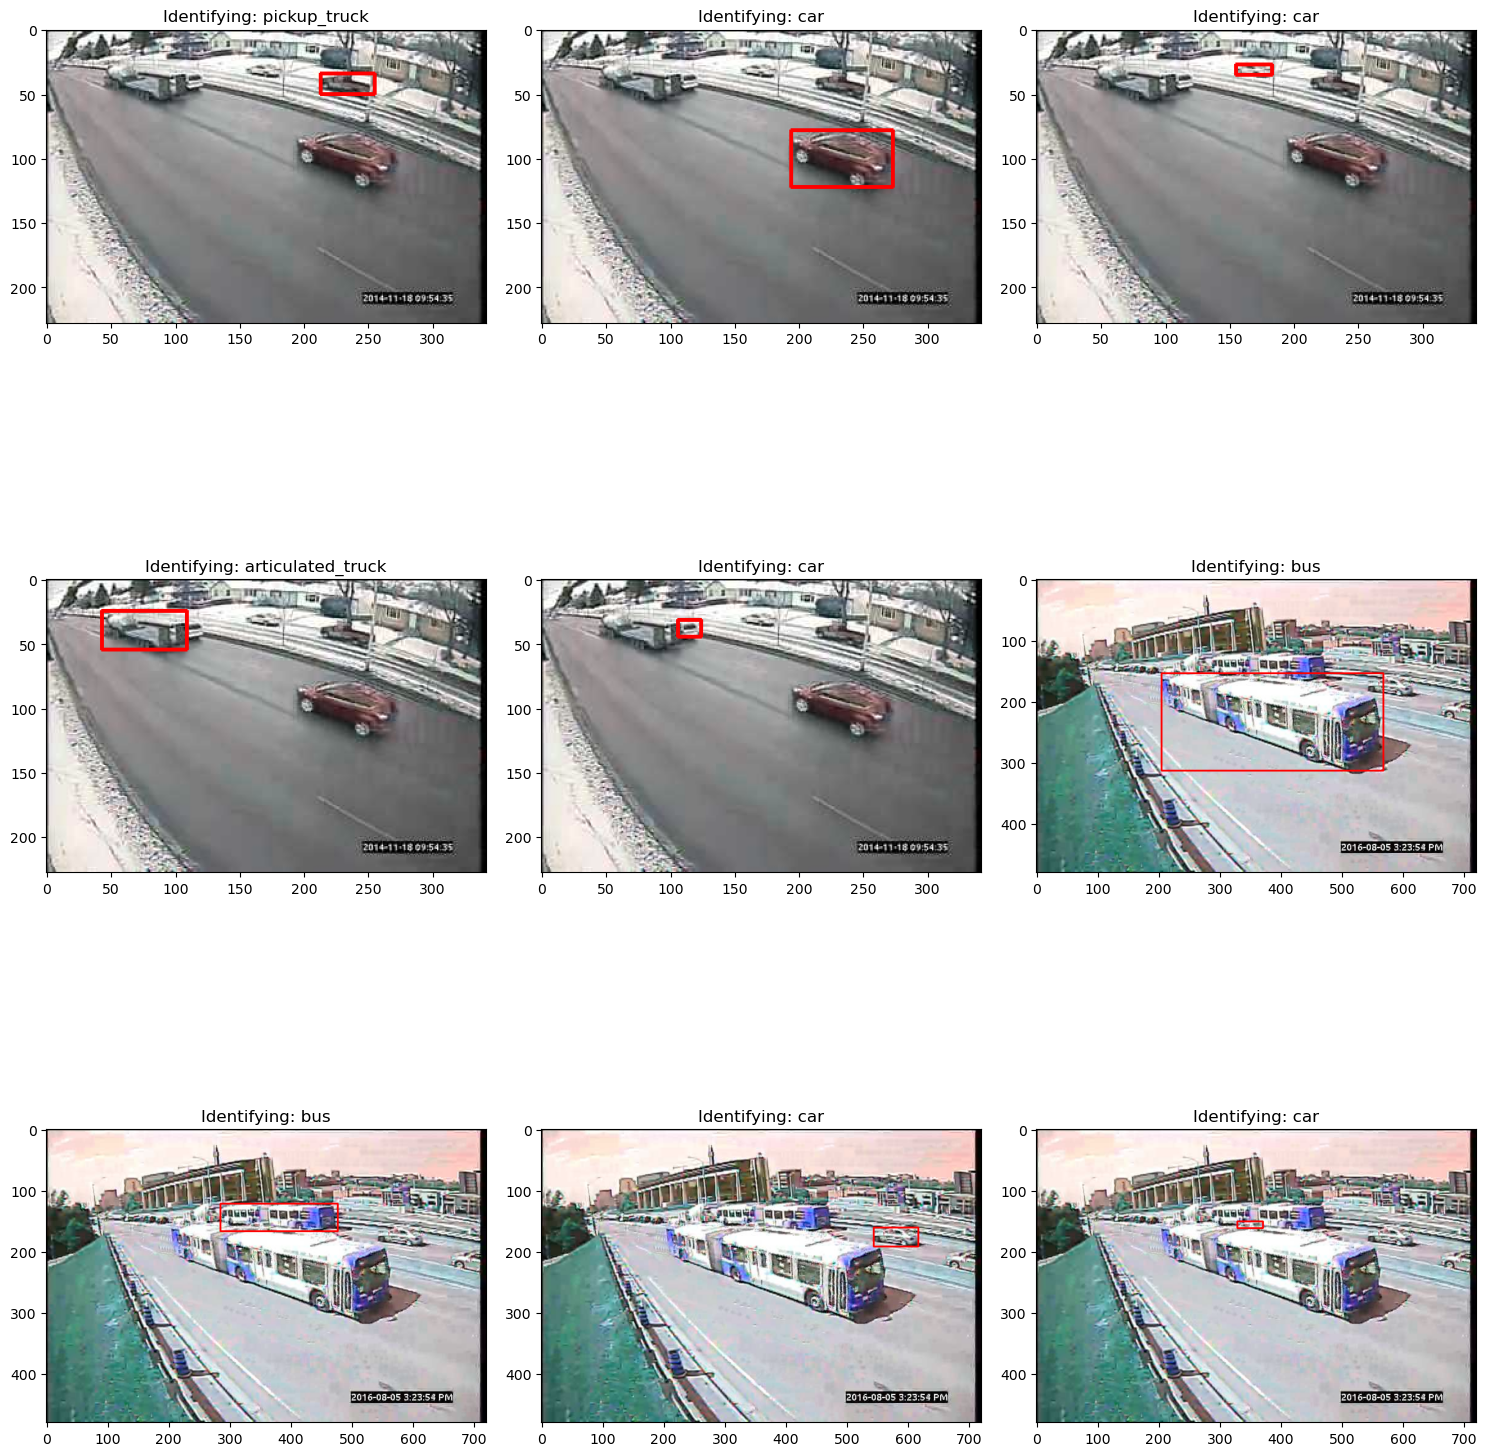

In [3]:
plt.figure(figsize=(15,18))

for i, image in enumerate(images_with_boxes[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(images_with_boxes[i])
    plt.title(f"Identifying: {labels_df['class'][i]}")

plt.tight_layout()

## Make an Impact 
To better understand the problem we are trying to solve, let's take a look at the reported Tesla Deaths and find out if we can make an impact with better modelling

In [4]:
#Get the reasons for the fatal accidents from Confirmed Autopilot Deaths
deaths = pd.read_csv('Tesla - Deaths.csv')
deaths[' Verified Tesla Autopilot Deaths '] = deaths[' Verified Tesla Autopilot Deaths '].replace([' - ', '-'], 0)
deaths[' Verified Tesla Autopilot Deaths '] = deaths[' Verified Tesla Autopilot Deaths '].fillna(0)
deaths[' Verified Tesla Autopilot Deaths '] = deaths[' Verified Tesla Autopilot Deaths '].astype('int32')
autopilot_deaths = deaths[deaths[' Verified Tesla Autopilot Deaths ']>=1]
reasons_list = autopilot_deaths[' Description '].dropna().tolist()
total_deaths = deaths[' Verified Tesla Autopilot Deaths '][:293].sum()
print(f'These {total_deaths} deaths could have been prevented with better classification standards built into the autopilot. Here are {len(reasons_list)} accidents that we can learn from:')
reasons_list

These 19 deaths could have been prevented with better classification standards built into the autopilot. Here are 16 accidents that we can learn from:


[' Tesla hits motorcycle ',
 ' Multi-car accident on highway ',
 ' Tesla hits motorcycle ',
 ' Motorcycle hit by Tesla ',
 ' Tesla hits parked tractor-trailer ',
 ' Pedestrian hit on shoulder ',
 ' Tesla strikes and kills a man standing next to his truck ',
 ' Tesla rear ends parked fire truck ',
 ' Tesla runs red light after exiting freeway ',
 ' Tesla rear ends Ford ',
 ' Tesla kills pedestrian ',
 ' Autopilot into 18 wheeler ',
 ' Sleeping Tesla driver kills motorcyclist ',
 ' Autopilot into highway barrier ',
 ' Autopilot into 18 wheeler ',
 ' AutoPilot into street sweeper ']

Of our **16 confirmed Autopilot death reasons** *4* were hitting **motorcycles**, *10* were the tesla **hitting another vehicle or obstacle it presumably didn't see.** The run red light could have been a misclassification by the vehicle and the reason for the Multi-car accident is unknown

**Let's note:** the majority of violations by the tesla were typically strange vehicles unlike a normal car **(ex. 18 wheelers, fire trucks, tractor trailer, motorcycles, street sweeper, or unidentified pedestrians)**

## Visualize Class Value Counts

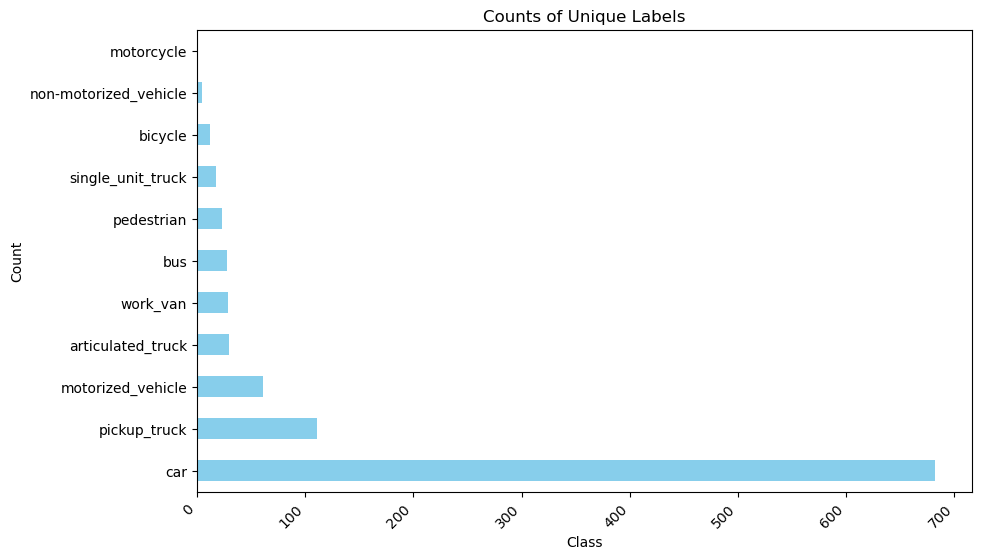

In [5]:
# Analyze the distribution of vehicle types in the limited dataset
class_counts = labels_df['class'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='barh', color='skyblue')
plt.title('Counts of Unique Labels')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

# 🚘 | Step 3: Preprocess the images

## Resize all Images for Our Models

In [6]:
if len(images_before_boxes) > 0:
    processed_images = [cv2.resize(img, (224, 224)) for img in images_before_boxes] 
    processed_images = np.array(processed_images)
    print("Images resized successfully.")

Images resized successfully.


# 📦 | Step 4:  Prepare the labels and bounding boxes

## One Hot Encode our Labels

In [12]:
labels = labels_df['class'].to_numpy()
bounding_boxes = labels_df[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()

# Convert labels to one-hot encoding
labels = pd.get_dummies(labels, dtype='int')
labels.head()

articulated_truck  bicycle  bus  car  motorcycle  motorized_vehicle  \
0                  0        0    0    0           0                  0   
1                  0        0    0    1           0                  0   
2                  0        0    0    1           0                  0   
3                  1        0    0    0           0                  0   
4                  0        0    0    1           0                  0   

   non-motorized_vehicle  pedestrian  pickup_truck  single_unit_truck  \
0                      0           0             1                  0   
1                      0           0             0                  0   
2                      0           0             0                  0   
3                      0           0             0                  0   
4                      0           0             0                  0   

   work_van  
0         0  
1         0  
2         0  
3         0  
4         0

## Create a DataFrame to Associate our Labels with a particular image id

In [13]:
answer_df = labels.copy()
answer_df['pic_id'] = labels_df['image_id']

## Create a Merged DF that will allow us to have all labels in an image per photo

In [14]:
# Make 1 one_hot output per picture that lists all vehicles in the image (so the model knows to identify all vehicles)
consolidated_df = answer_df.groupby('pic_id').max().reset_index()
merged_df = pd.merge(answer_df[['pic_id']], consolidated_df, on='pic_id', how='left')
merged_df.head(3)

pic_id  articulated_truck  bicycle  bus  car  motorcycle  \
0  00000000                  1        0    0    1           0   
1  00000000                  1        0    0    1           0   
2  00000000                  1        0    0    1           0   

   motorized_vehicle  non-motorized_vehicle  pedestrian  pickup_truck  \
0                  0                      0           0             1   
1                  0                      0           0             1   
2                  0                      0           0             1   

   single_unit_truck  work_van  
0                  0         0  
1                  0         0  
2                  0         0

# ✂️ | Step 5: Split the data into training and testing sets

## A. Split for One Label Per Image

In [15]:
#Train for A. One Label Per Image
X_train_ind, X_test_ind, y_train_ind, y_test_ind, bbox_train_ind, bbox_test_ind = train_test_split(processed_images,
                                                                           labels,
                                                                           bounding_boxes, test_size=0.2,
                                                                           random_state=42)

## B. Split for All Labels Per Image

In [77]:
#Train for B. All Labels Per Image
X_train, X_test, y_train, y_test, bbox_train, bbox_test = train_test_split(processed_images,
                                                                           merged_df.drop(columns='pic_id'),
                                                                           bounding_boxes, test_size=0.2,
                                                                           random_state=42)

## Normalize for Baseline Model
* Note: EfficientNet has an inbuilt normalization layer so we will be passing the original values of x_train/x_test above into those models

#### Normalized A. One Label Per Image

In [17]:
X_train_ind_normalized, X_test_ind_normalized = X_train_ind/255, X_test_ind/255

#### Normalized B. All Labels Per Image

In [18]:
X_train_normalized, X_test_normalized = X_train/255, X_test/255

# 🤖 | Step 6: Model Experiments:
(NO BOUNDING BOXES DRAWN IN THE TRAIN DATA)

#### 1. **3 Single Conv2D layers with Max Pooling between (basic structure baseline)**

**A. One Label Per Image:**
  - *Label Accuracy:* Train: 48.75%, Test: 33.50%
  - **Bounding Box MSE: Train: 18734.74, Test: 20656.08**

**B. All Labels Included Per Image:**
  - *Label Accuracy:* Train: 40.13%, Test: 30.50%
  - *Bounding Box MSE:* Train: 18663.95, Test: 21063.34

#### 2. **EfficientNet feature extractor**

**A. One Label Per Image:**
  - *Label Accuracy:* Train: 70.38% , Test: 68.00%
  - *Bounding Box MSE:* Train: 24349.24, Test: 24192.67

**B. All Labels Included Per Image:**
  - **Label Accuracy: Train: 59.38% , Test: 68.50%**
  - *Bounding Box MSE:* Train: 24445.63, Test: 24268.58
      
#### 3. **EfficientNet 5 trainable layers (with reduced LR)**

**A. One Label Per Image:**
  - *Label Accuracy:* Train: 67.37% , Test: 68.00%
  - *Bounding Box MSE:* Train: 24082.48, Test: 24606.18

**B. All Labels Included Per Image:**
  - *Label Accuracy:* Train: 61.62%, Test: 68.00% 
  - *Bounding Box MSE:* Train: 24986.67, Test: 252166.95

Through 6 experiments we discover that for finding bounding boxes it is advantageous to use our baseline model or feature extractor. But in both instances it was better to use the 1 label per image dataset weights. For the Labels we found it was better to include all labels per image and use our Efficient Net model.

For optimization: Lets try using the images with no bounding boxes on them to predict bounding boxes in one model and use another model to predict labels using images without bounding boxes and all labels so the model can find all types of vehicles in an image. We can then combine these models to accurately find labels and bounding boxes.

### Setting up For Model Experiments

#### Create Checkpoint Directory for Saved Models

In [19]:
# Create a directory for storing model checkpoints if it doesn't exist
checkpoint_dir = 'model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

#### Shared Model Parameters

In [20]:
input_shape = processed_images[0].shape
num_classes = y_train.shape[1]

### A. One Label Per Image

In [21]:
labels.head(1)

articulated_truck  bicycle  bus  car  motorcycle  motorized_vehicle  \
0                  0        0    0    0           0                  0   

   non-motorized_vehicle  pedestrian  pickup_truck  single_unit_truck  \
0                      0           0             1                  0   

   work_van  
0         0

### B. All Labels Per Image

In [22]:
merged_df.drop(columns='pic_id').head(1)

articulated_truck  bicycle  bus  car  motorcycle  motorized_vehicle  \
0                  1        0    0    1           0                  0   

   non-motorized_vehicle  pedestrian  pickup_truck  single_unit_truck  \
0                      0           0             1                  0   

   work_van  
0         0

## Baseline: A. One Label Per Image

In [23]:
tf.random.set_seed(42)

model_1a = create_model(input_shape, num_classes, name='model_1a')


model_1a.compile(optimizer='adam',
              loss={'vehicle_class': 'categorical_crossentropy', 'bounding_box': 'mse'},
              metrics={'vehicle_class': 'accuracy', 'bounding_box': 'mae'})

history_1a = model_1a.fit(X_train_ind_normalized, {'vehicle_class': y_train_ind, 'bounding_box': bbox_train_ind}, epochs=10, validation_data=(X_test_ind_normalized, {'vehicle_class': y_test_ind, 'bounding_box': bbox_test_ind}), callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True), model_checkpoint(model_1a, checkpoint_dir)])

Epoch 1/10
25/25 [==============================] - 9s 340ms/step - loss: 39776.4336 - vehicle_class_loss: 59.7445 - bounding_box_loss: 39716.6875 - vehicle_class_accuracy: 0.4387 - bounding_box_mae: 150.3537 - val_loss: 27844.4434 - val_vehicle_class_loss: 51.6095 - val_bounding_box_loss: 27792.8320 - val_vehicle_class_accuracy: 0.1950 - val_bounding_box_mae: 129.6181
Epoch 2/10
25/25 [==============================] - 8s 330ms/step - loss: 27280.3516 - vehicle_class_loss: 43.3181 - bounding_box_loss: 27237.0293 - vehicle_class_accuracy: 0.5050 - bounding_box_mae: 129.7984 - val_loss: 25245.1406 - val_vehicle_class_loss: 40.5755 - val_bounding_box_loss: 25204.5645 - val_vehicle_class_accuracy: 0.1500 - val_bounding_box_mae: 126.3296
Epoch 3/10
25/25 [==============================] - 8s 324ms/step - loss: 24853.3047 - vehicle_class_loss: 35.4350 - bounding_box_loss: 24817.8691 - vehicle_class_accuracy: 0.4238 - bounding_box_mae: 121.7154 - val_loss: 23514.5449 - val_vehicle_class_loss

### Evaluate Baseline A

In [24]:
test_results = model_1a.evaluate(X_test_ind_normalized, {'vehicle_class': y_test_ind, 'bounding_box': bbox_test_ind}, verbose=2)
baseline_results_a = {'Accuracy': round(test_results[3] * 100, 2), 'Box_MAE': round(test_results[4], 2)}
print('\nTest results:', baseline_results_a)

7/7 - 1s - loss: 20665.8203 - vehicle_class_loss: 9.7402 - bounding_box_loss: 20656.0801 - vehicle_class_accuracy: 0.3350 - bounding_box_mae: 111.5367 - 524ms/epoch - 75ms/step

Test results: {'Accuracy': 33.5, 'Box_MAE': 111.54}


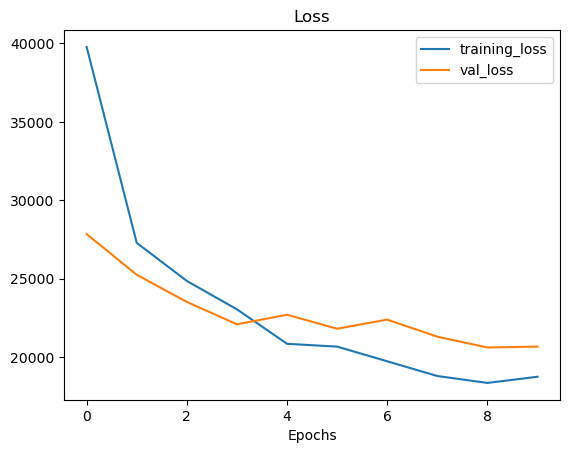

In [25]:
plot_loss_regression(history_1a)

## Baseline: B. All Labels Included Per Image

In [26]:
tf.random.set_seed(42)

model_1b = create_model(input_shape, num_classes, name='model_1b')


model_1b.compile(optimizer='adam',
              loss={'vehicle_class': 'categorical_crossentropy', 'bounding_box': 'mse'},
              metrics={'vehicle_class': 'accuracy', 'bounding_box': 'mae'})

history_1b = model_1b.fit(X_train_normalized, {'vehicle_class': y_train, 'bounding_box': bbox_train}, epochs=10, validation_data=(X_test_normalized, {'vehicle_class': y_test, 'bounding_box': bbox_test}), callbacks=[model_checkpoint(model_1b, checkpoint_dir)])

Epoch 1/10
25/25 [==============================] - 9s 341ms/step - loss: 42177.9883 - vehicle_class_loss: 333.8683 - bounding_box_loss: 41844.1172 - vehicle_class_accuracy: 0.0613 - bounding_box_mae: 155.0911 - val_loss: 27714.9473 - val_vehicle_class_loss: 204.6782 - val_bounding_box_loss: 27510.2695 - val_vehicle_class_accuracy: 0.0000e+00 - val_bounding_box_mae: 130.7289
Epoch 2/10
25/25 [==============================] - 8s 325ms/step - loss: 27108.6816 - vehicle_class_loss: 144.3674 - bounding_box_loss: 26964.3145 - vehicle_class_accuracy: 0.3212 - bounding_box_mae: 129.2257 - val_loss: 25258.5527 - val_vehicle_class_loss: 117.7151 - val_bounding_box_loss: 25140.8379 - val_vehicle_class_accuracy: 0.7250 - val_bounding_box_mae: 125.9416
Epoch 3/10
25/25 [==============================] - 8s 324ms/step - loss: 23430.7891 - vehicle_class_loss: 94.2869 - bounding_box_loss: 23336.5059 - vehicle_class_accuracy: 0.4850 - bounding_box_mae: 118.2868 - val_loss: 22746.4219 - val_vehicle_cl

### Evaluate Baseline B

In [27]:
test_results = model_1b.evaluate(X_test_normalized, {'vehicle_class': y_test, 'bounding_box': bbox_test}, verbose=2)
baseline_results_b = {'Accuracy': round(test_results[3] * 100, 2), 'Box_MAE': round(test_results[4], 2)}
print('\nTest results:', baseline_results_b)

7/7 - 1s - loss: 21157.5020 - vehicle_class_loss: 94.1699 - bounding_box_loss: 21063.3359 - vehicle_class_accuracy: 0.3050 - bounding_box_mae: 110.4194 - 528ms/epoch - 75ms/step

Test results: {'Accuracy': 30.5, 'Box_MAE': 110.42}


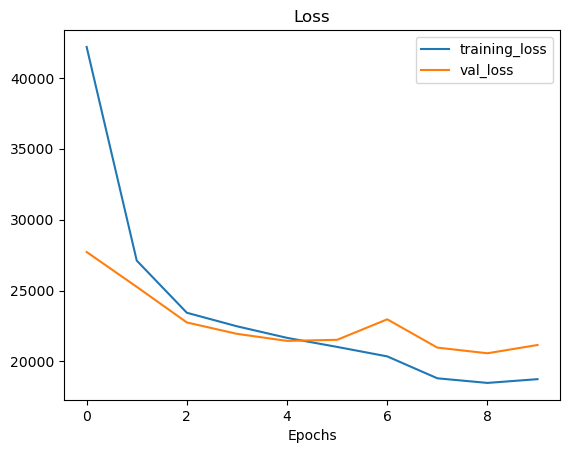

In [28]:
plot_loss_regression(history_1b)

## EfficientNetV2 Feature Extractor A

In [30]:
tf.random.set_seed(42)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

model_2a = create_efficientnet_model(input_shape, num_classes, base_model, name='model_2a')


model_2a.compile(optimizer='adam',
              loss={'vehicle_class': 'categorical_crossentropy', 'bounding_box': 'mse'},
              metrics={'vehicle_class': 'accuracy', 'bounding_box': 'mae'})

history_2a = model_2a.fit(X_train_ind, {'vehicle_class': y_train_ind, 'bounding_box': bbox_train_ind}, batch_size=32, epochs=10, validation_data=(X_test_ind, {'vehicle_class': y_test_ind, 'bounding_box': bbox_test_ind}), callbacks=[model_checkpoint(model_2a, checkpoint_dir)])

Epoch 1/10
25/25 [==============================] - 8s 266ms/step - loss: 88642.0938 - vehicle_class_loss: 1.4384 - bounding_box_loss: 88640.6562 - vehicle_class_accuracy: 0.6237 - bounding_box_mae: 232.6057 - val_loss: 84221.5938 - val_vehicle_class_loss: 1.1876 - val_bounding_box_loss: 84220.3984 - val_vehicle_class_accuracy: 0.6850 - val_bounding_box_mae: 225.5072
Epoch 2/10
25/25 [==============================] - 6s 240ms/step - loss: 78734.3125 - vehicle_class_loss: 1.1552 - bounding_box_loss: 78733.1484 - vehicle_class_accuracy: 0.6800 - bounding_box_mae: 213.5158 - val_loss: 72338.3125 - val_vehicle_class_loss: 1.1254 - val_bounding_box_loss: 72337.1953 - val_vehicle_class_accuracy: 0.6850 - val_bounding_box_mae: 202.6922
Epoch 3/10
25/25 [==============================] - 6s 245ms/step - loss: 65210.6133 - vehicle_class_loss: 1.0768 - bounding_box_loss: 65209.5234 - vehicle_class_accuracy: 0.6775 - bounding_box_mae: 186.9392 - val_loss: 57733.4844 - val_vehicle_class_loss: 1.0

### Evaluate Feature Extractor A

In [31]:
test_results = model_2a.evaluate(X_test_ind, {'vehicle_class': y_test_ind, 'bounding_box': bbox_test_ind}, verbose=2)
model_2a_results = {'Accuracy': round(test_results[3] * 100, 2), 'Box_MAE': round(test_results[4], 2)}
print('\nFeature Extractor A:', model_2a_results)
print('Baseline A:', baseline_results_a)

7/7 - 1s - loss: 24193.7402 - vehicle_class_loss: 1.0735 - bounding_box_loss: 24192.6680 - vehicle_class_accuracy: 0.6800 - bounding_box_mae: 121.7867 - 1s/epoch - 187ms/step

Feature Extractor A: {'Accuracy': 68.0, 'Box_MAE': 121.79}
Baseline A: {'Accuracy': 33.5, 'Box_MAE': 111.54}


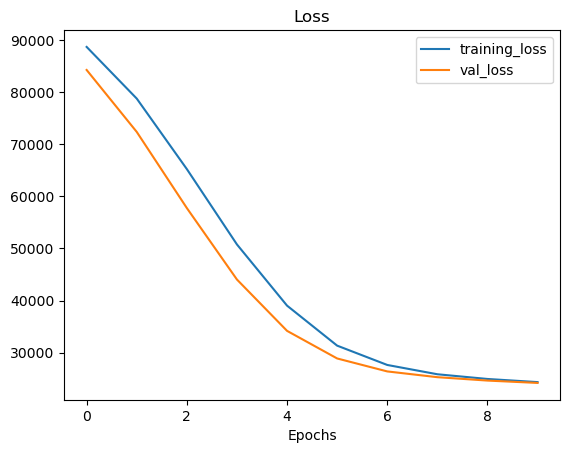

In [32]:
plot_loss_regression(history_2a)

## EfficientNetV2 Feature Extractor B

In [35]:
tf.random.set_seed(42)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

model_2b = create_efficientnet_model(input_shape, num_classes, base_model, name='model_2b')


model_2b.compile(optimizer='adam',
              loss={'vehicle_class': 'categorical_crossentropy', 'bounding_box': 'mse'},
              metrics={'vehicle_class': 'accuracy', 'bounding_box': 'mae'})

history_2b = model_2b.fit(X_train, {'vehicle_class': y_train, 'bounding_box': bbox_train}, epochs=10, validation_data=(X_test, {'vehicle_class': y_test, 'bounding_box': bbox_test}), callbacks=[model_checkpoint(model_2b, checkpoint_dir)])

Epoch 1/10
25/25 [==============================] - 9s 282ms/step - loss: 89471.3906 - vehicle_class_loss: 4.3062 - bounding_box_loss: 89467.1016 - vehicle_class_accuracy: 0.2925 - bounding_box_mae: 233.4903 - val_loss: 85539.1016 - val_vehicle_class_loss: 3.4201 - val_bounding_box_loss: 85535.6797 - val_vehicle_class_accuracy: 0.7200 - val_bounding_box_mae: 226.8664
Epoch 2/10
25/25 [==============================] - 7s 263ms/step - loss: 80468.9766 - vehicle_class_loss: 3.6281 - bounding_box_loss: 80465.3438 - vehicle_class_accuracy: 0.6538 - bounding_box_mae: 215.1632 - val_loss: 74189.9844 - val_vehicle_class_loss: 3.2389 - val_bounding_box_loss: 74186.7344 - val_vehicle_class_accuracy: 0.7150 - val_bounding_box_mae: 203.8250
Epoch 3/10
25/25 [==============================] - 6s 247ms/step - loss: 67293.6250 - vehicle_class_loss: 3.4894 - bounding_box_loss: 67290.1328 - vehicle_class_accuracy: 0.6162 - bounding_box_mae: 188.5409 - val_loss: 59612.8906 - val_vehicle_class_loss: 3.1

### Evaluate Feature Extractor B

In [36]:
test_results = model_2b.evaluate(X_test, {'vehicle_class': y_test, 'bounding_box': bbox_test}, verbose=2)
model_2b_results = {'Accuracy': round(test_results[3] * 100, 2), 'Box_MAE': round(test_results[4], 2)}
print('\nFeature Extractor B:', model_2b_results)
print('Baseline B:', baseline_results_b)

7/7 - 1s - loss: 24271.7227 - vehicle_class_loss: 3.1370 - bounding_box_loss: 24268.5820 - vehicle_class_accuracy: 0.6850 - bounding_box_mae: 121.9456 - 1s/epoch - 179ms/step

Feature Extractor B: {'Accuracy': 68.5, 'Box_MAE': 121.95}
Baseline B: {'Accuracy': 30.5, 'Box_MAE': 110.42}


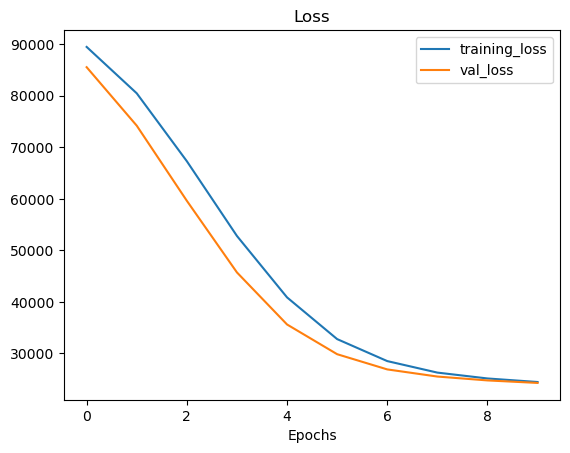

In [37]:
plot_loss_regression(history_2b)

## Updating 5 Layers in Base Model to be Trainable

In [38]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
    layer.trainable = False

for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_7 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

## Build EfficientNet trainable A

In [40]:
model_3a = create_efficientnet_model(input_shape, num_classes, base_model, name='model_3a')

model_3a.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=.0001), #Reduce LR as to not dramatically change weights in pretrained model
              loss={'vehicle_class': 'categorical_crossentropy', 'bounding_box': 'mse'},
              metrics={'vehicle_class': 'accuracy', 'bounding_box': 'mae'})

history_3a = model_3a.fit(X_train_ind, {'vehicle_class': y_train_ind, 'bounding_box': bbox_train_ind}, batch_size=32, epochs=20, initial_epoch=history_2a.epoch[-1], validation_data=(X_test_ind, {'vehicle_class': y_test_ind, 'bounding_box': bbox_test_ind}), callbacks=[model_checkpoint(model_3a, checkpoint_dir)])

Epoch 10/20
25/25 [==============================] - 9s 281ms/step - loss: 83102.0391 - vehicle_class_loss: 6.2917 - bounding_box_loss: 83095.7422 - vehicle_class_accuracy: 0.0362 - bounding_box_mae: 221.2027 - val_loss: 75824.4219 - val_vehicle_class_loss: 2.1873 - val_bounding_box_loss: 75822.2422 - val_vehicle_class_accuracy: 0.1200 - val_bounding_box_mae: 207.5781
Epoch 11/20
25/25 [==============================] - 6s 253ms/step - loss: 70018.8750 - vehicle_class_loss: 1.5877 - bounding_box_loss: 70017.2812 - vehicle_class_accuracy: 0.5950 - bounding_box_mae: 194.5930 - val_loss: 62487.7188 - val_vehicle_class_loss: 1.4691 - val_bounding_box_loss: 62486.2461 - val_vehicle_class_accuracy: 0.6800 - val_bounding_box_mae: 181.3826
Epoch 12/20
25/25 [==============================] - 6s 253ms/step - loss: 57342.1367 - vehicle_class_loss: 1.4441 - bounding_box_loss: 57340.6836 - vehicle_class_accuracy: 0.6538 - bounding_box_mae: 169.8320 - val_loss: 50059.0586 - val_vehicle_class_loss: 

### Evaluate EfficientNet Trainable A

In [41]:
test_results = model_3a.evaluate(X_test_ind, {'vehicle_class': y_test_ind, 'bounding_box': bbox_test_ind}, verbose=2)
model_3a_results = {'Accuracy': round(test_results[3] * 100, 2), 'Box_MAE': round(test_results[4], 2)}
print('\nEfficientNetV2 5 Trainable Layers A:', model_3a_results)
print('Feature Extractor A:', model_2a_results)
print('Baseline A:', baseline_results_a)

7/7 - 2s - loss: 24607.4551 - vehicle_class_loss: 1.2793 - bounding_box_loss: 24606.1777 - vehicle_class_accuracy: 0.6800 - bounding_box_mae: 122.9419 - 2s/epoch - 218ms/step

EfficientNetV2 5 Trainable Layers A: {'Accuracy': 68.0, 'Box_MAE': 122.94}
Feature Extractor A: {'Accuracy': 68.0, 'Box_MAE': 121.79}
Baseline A: {'Accuracy': 33.5, 'Box_MAE': 111.54}


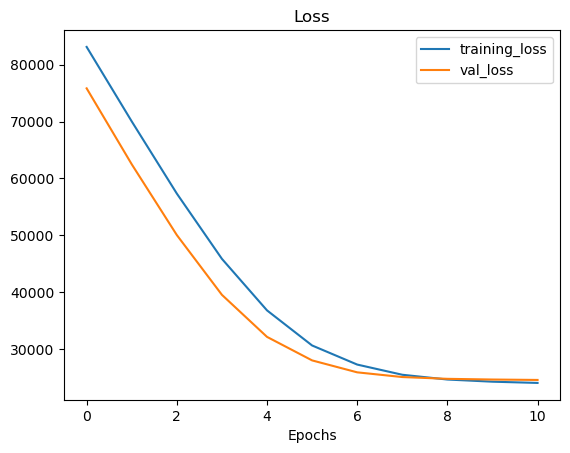

In [42]:
plot_loss_regression(history_3a)

## Build EfficientNet trainable B

In [43]:
tf.random.set_seed(42)

model_3b = create_efficientnet_model(input_shape, num_classes, base_model, name='model_3b')
model_3b.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=.0001), 
              loss={'vehicle_class': 'categorical_crossentropy', 'bounding_box': 'mse'},
              metrics={'vehicle_class': 'accuracy', 'bounding_box': 'mae'})

history_3b = model_3b.fit(X_train, {'vehicle_class': y_train, 'bounding_box': bbox_train}, batch_size=32, epochs=20, initial_epoch=10, validation_data=(X_test, {'vehicle_class': y_test, 'bounding_box': bbox_test}), callbacks=model_checkpoint(model_3b, checkpoint_dir))

Epoch 11/20
25/25 [==============================] - 10s 319ms/step - loss: 85903.9062 - vehicle_class_loss: 18.3115 - bounding_box_loss: 85885.6016 - vehicle_class_accuracy: 0.4563 - bounding_box_mae: 226.5573 - val_loss: 79620.1719 - val_vehicle_class_loss: 13.9343 - val_bounding_box_loss: 79606.2344 - val_vehicle_class_accuracy: 0.7250 - val_bounding_box_mae: 215.8678
Epoch 12/20
25/25 [==============================] - 7s 300ms/step - loss: 75563.6016 - vehicle_class_loss: 10.9296 - bounding_box_loss: 75552.6719 - vehicle_class_accuracy: 0.6250 - bounding_box_mae: 206.8664 - val_loss: 70131.7344 - val_vehicle_class_loss: 7.5896 - val_bounding_box_loss: 70124.1484 - val_vehicle_class_accuracy: 0.6800 - val_bounding_box_mae: 197.9317
Epoch 13/20
25/25 [==============================] - 7s 292ms/step - loss: 66225.3438 - vehicle_class_loss: 7.0457 - bounding_box_loss: 66218.2969 - vehicle_class_accuracy: 0.6325 - bounding_box_mae: 189.4344 - val_loss: 60641.5234 - val_vehicle_class_lo

### Evaluate EfficientNet Trainable B

In [44]:
test_results = model_3b.evaluate(X_test, {'vehicle_class': y_test, 'bounding_box': bbox_test}, verbose=2)
model_3b_results = {'Accuracy': round(test_results[3] * 100, 2), 'Box_MAE': round(test_results[4], 2)}
print('\nEfficientNetV2 5 Trainable Layers B:', model_3b_results)
print('Feature Extractor B:', model_2b_results)
print('Baseline B:', baseline_results_b)

7/7 - 1s - loss: 25172.8105 - vehicle_class_loss: 5.8681 - bounding_box_loss: 25166.9453 - vehicle_class_accuracy: 0.6800 - bounding_box_mae: 123.0516 - 1s/epoch - 204ms/step

EfficientNetV2 5 Trainable Layers B: {'Accuracy': 68.0, 'Box_MAE': 123.05}
Feature Extractor B: {'Accuracy': 68.5, 'Box_MAE': 121.95}
Baseline B: {'Accuracy': 30.5, 'Box_MAE': 110.42}


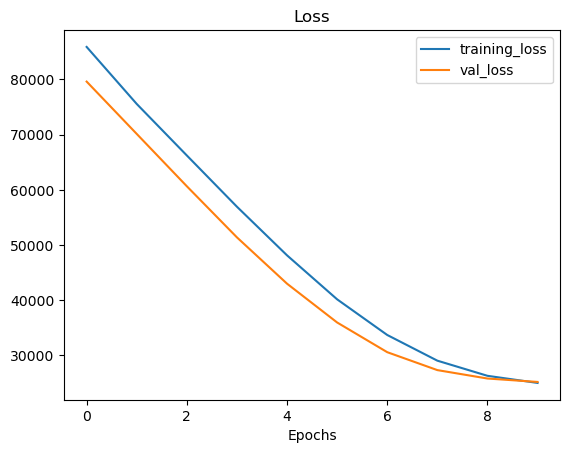

In [45]:
plot_loss_regression(history_3b)

# 💪 | Step 7: Using what we've learned to create an Optimal Model

### *Goal*
We discovered through our experiments that our Baseline 1 model was the best at predicting bounding boxes with the lowest MSE but our EfficientNet Feature Extractor (No Trainable Layers) B. (All Labels) was better for classification. Lets decide which model we want to tune:

In [46]:
results_df = pd.DataFrame([baseline_results_a, baseline_results_b, model_2a_results, model_2b_results, model_3a_results, model_3b_results])
model_names = ['Baseline_A', 'Baseline_B', 'Model_2A', 'Model_2B', 'Model_3A', 'Model_3B']
results_df.index = model_names
results_df['Model'] = model_names
results_df

Accuracy  Box_MAE       Model
Baseline_A      33.5   111.54  Baseline_A
Baseline_B      30.5   110.42  Baseline_B
Model_2A        68.0   121.79    Model_2A
Model_2B        68.5   121.95    Model_2B
Model_3A        68.0   122.94    Model_3A
Model_3B        68.0   123.05    Model_3B

Though our Baseline B Model achieved the best Bounding Box loss the loss curve for Model 2B was steep, hinting that with extended training it could surpass Baseline B. Given that it already has quite the head start on the Baseline with Accuracy, I believe it would be best to devote more training time to Model 2B. EfficientNetV2 with no Trainable layers

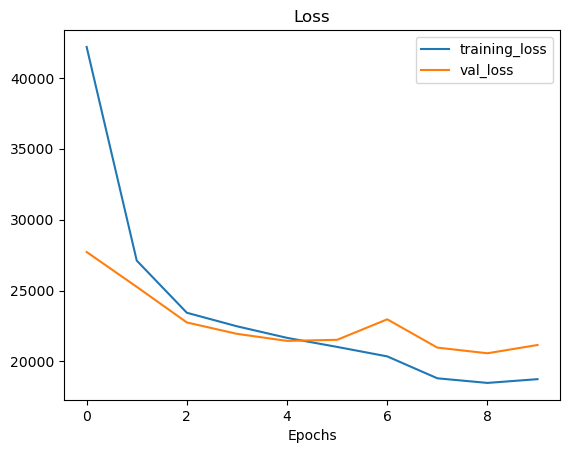

In [47]:
plot_loss_regression(history_1b)

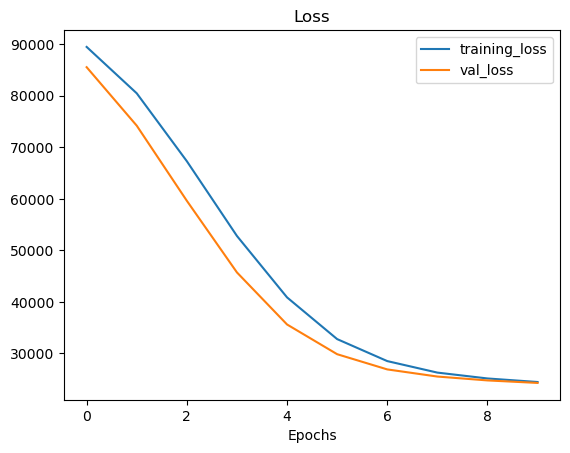

In [48]:
plot_loss_regression(history_2b)

### Train our Optimal Model for more Epochs with Callbacks

We will train our best model on 100 epochs and utilize the Early Stopping and ReduceLR callbacks to make sure to receive our best model

In [51]:
best_history = model_2b.fit(X_train, {'vehicle_class': y_train, 'bounding_box': bbox_train},
                            epochs=100, initial_epoch=history_2b.epoch[-1],
                            validation_data=(X_test, {'vehicle_class': y_test, 'bounding_box': bbox_test}),
                            callbacks=[model_checkpoint(model_2b, checkpoint_dir),
                                      tf.keras.callbacks.EarlyStopping(monitor='val_bounding_box_loss',
                                                                       patience=25, restore_best_weights=True),
                                      tf.keras.callbacks.ReduceLROnPlateau(patience=15, verbose=1, monitor='val_bounding_box_loss')])

Epoch 10/100
25/25 [==============================] - 6s 251ms/step - loss: 23939.8945 - vehicle_class_loss: 56.4763 - bounding_box_loss: 23883.4180 - vehicle_class_accuracy: 0.5375 - bounding_box_mae: 117.5744 - val_loss: 24525.3594 - val_vehicle_class_loss: 32.8759 - val_bounding_box_loss: 24492.4824 - val_vehicle_class_accuracy: 0.7400 - val_bounding_box_mae: 119.2247 - lr: 0.0010
Epoch 11/100
25/25 [==============================] - 6s 247ms/step - loss: 23749.2324 - vehicle_class_loss: 57.7618 - bounding_box_loss: 23691.4707 - vehicle_class_accuracy: 0.5500 - bounding_box_mae: 117.4049 - val_loss: 24370.4551 - val_vehicle_class_loss: 33.1597 - val_bounding_box_loss: 24337.2949 - val_vehicle_class_accuracy: 0.4950 - val_bounding_box_mae: 119.1633 - lr: 0.0010
Epoch 12/100
25/25 [==============================] - 6s 254ms/step - loss: 23643.6934 - vehicle_class_loss: 58.3066 - bounding_box_loss: 23585.3867 - vehicle_class_accuracy: 0.5562 - bounding_box_mae: 117.4836 - val_loss: 242

#### Evaluate our Optimal Model

In [52]:
test_results = model_2b.evaluate(X_test, {'vehicle_class': y_test, 'bounding_box': bbox_test}, verbose=2)
best_model_results = {'Accuracy': round(test_results[3] * 100, 2), 'Box_MAE': round(test_results[4], 2)}
print('\nOptimized Model After 100 Epochs:', best_model_results)
print('Original Model Trained on 10 Epochs:', model_2b_results)

7/7 - 1s - loss: 23165.8945 - vehicle_class_loss: 169.8273 - bounding_box_loss: 22996.0684 - vehicle_class_accuracy: 0.4950 - bounding_box_mae: 117.5764 - 1s/epoch - 205ms/step

Optimized Model After 100 Epochs: {'Accuracy': 49.5, 'Box_MAE': 117.58}
Original Model Trained on 10 Epochs: {'Accuracy': 68.5, 'Box_MAE': 121.95}


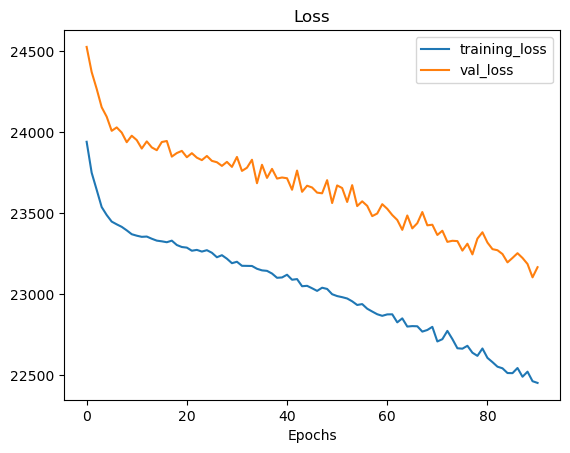

In [53]:
plot_loss_regression(best_history)

After the additional training we can see that our accuracy actually **decreased** and going throught the history of training we can see the accuracy jumped around quite a bit and we can see the loss jumped around quite a bit and shows a good amount of seperation between the train and test sets. Let's theorize why that is.

* The sample images are multiple of the same image per label and bounding box. So presumably our model is seeing the same image and is expected to predict the correct label and bounding box for each even though we are giving it the same input.

**How Could we fix this**
We are left with a few choices to address this issue. I tried the first solution where the model could predict multiple labels per image. This could theoretically fix the multi label issue except that it only counts 1 vehicle of a particular class per image. So if there are say, 10 cars in an image the expected output would be a 1 for car.

* Allow the model to predict multiple boxes per image
  The issue with this approach is that different images have a different amount of boxes. So we could create a new df allowing 1 row per image. Each row would have all labels associated with that image and the coordinates of all boxes. We could find which image has the most boxes then pad the rest of the images with 0's in the additional bounding boxes so all our inputs are the same shape, HOWEVER:
  1. Giving 0's for bounding box locations will throw an error as there is no 0th pixel in our images
  2. If we were to deploy this model into production and an image is passed through the model with even more bounding boxes/labels than our image we used for the most entires, our model won't be able to take the image.

**SO WHAT CAN WE DO???**
* Lucky for us there is just the model that can help us when predicting an unknown number of labels and an unknown number of bounding boxes per image. **YOLO**

After we visualize how well/badly our optimized model did to plot the bounding boxes on the test images, we will build a YOLOv8 model and feed it our same dataset

#### Creating the Same split with unaltered photo size to show bounding box accurate locations

In [78]:
X_train_original, X_test_original, y_train_original, y_test_original, bbox_train_original, bbox_test_original = train_test_split(images_before_boxes,
                                                                           merged_df.drop(columns='pic_id'),
                                                                           bounding_boxes, test_size=0.2,
                                                                           random_state=42)

# 🧪 | Step 8: Inferencing and Visualization

### Define a function that will allow us to plot our predicted bounding boxes with our actual boxes per image

In [155]:
def plot_bounding_boxes_with_predictions(images, labels, labels_df, class_names, bbox_preds, figsize=(35, 15)):
    num_images = 9
    
    plt.figure(figsize=figsize)
    
    for i in range(num_images):
        image = images[i]
        plt.subplot(3, 3, i+1)
        plt.imshow(image)
        
        # Retrieve actual bounding box coordinates
        x_min_actual = labels_df[i][0]
        y_min_actual = labels_df[i][1]
        x_max_actual = labels_df[i][2]
        y_max_actual = labels_df[i][3]
        
        # Calculate width and height of the actual bounding box
        width_actual = x_max_actual - x_min_actual
        height_actual = y_max_actual - y_min_actual
        
        # Draw actual bounding box in red
        bbox_actual = patches.Rectangle((x_min_actual, y_min_actual), width_actual, height_actual,
                                         linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(bbox_actual)
        
        # Retrieve predicted bounding box coordinates from bbox_preds
        x_min_pred, y_min_pred, x_max_pred, y_max_pred = bbox_preds[1][i]
        
        # Calculate width and height of the predicted bounding box
        width_pred = x_max_pred - x_min_pred
        height_pred = y_max_pred - y_min_pred
        
        # Draw predicted bounding box in green
        bbox_pred = patches.Rectangle((x_min_pred, y_min_pred), width_pred, height_pred,
                                      linewidth=2, edgecolor='g', facecolor='none')
        plt.gca().add_patch(bbox_pred)

    # Get indices where prediction_array has value 1
        actual_class = labels.values[i]
        class_prediction = np.where(bbox_preds[0][i] >= 0.5, 1, 0)
        predicted_indices = np.where(class_prediction == 1)[0]
        actual_indices = np.where(actual_class ==1)[0]
            
            # Map indices to class names using the provided class_names list
        predicted_class_names = [class_names[idx] for idx in predicted_indices]
        actual_class_names = [class_names[idx] for idx in actual_indices]
            
        
        plt.title(f"Predicted Labels: {predicted_class_names} \nActual: {actual_class_names}", fontsize=25)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

#### Link Class Names to our One Hot Encoding

In [123]:
class_names = merged_df.columns[1:]

#### Make Predictions with our best model

In [62]:
# Get model predictions for X_test
bbox_preds_test = model_2b.predict(X_test)

7/7 [==============================] - 1s 195ms/step


Green Boxes: Predicted Box
Red Boxes: Actual Box


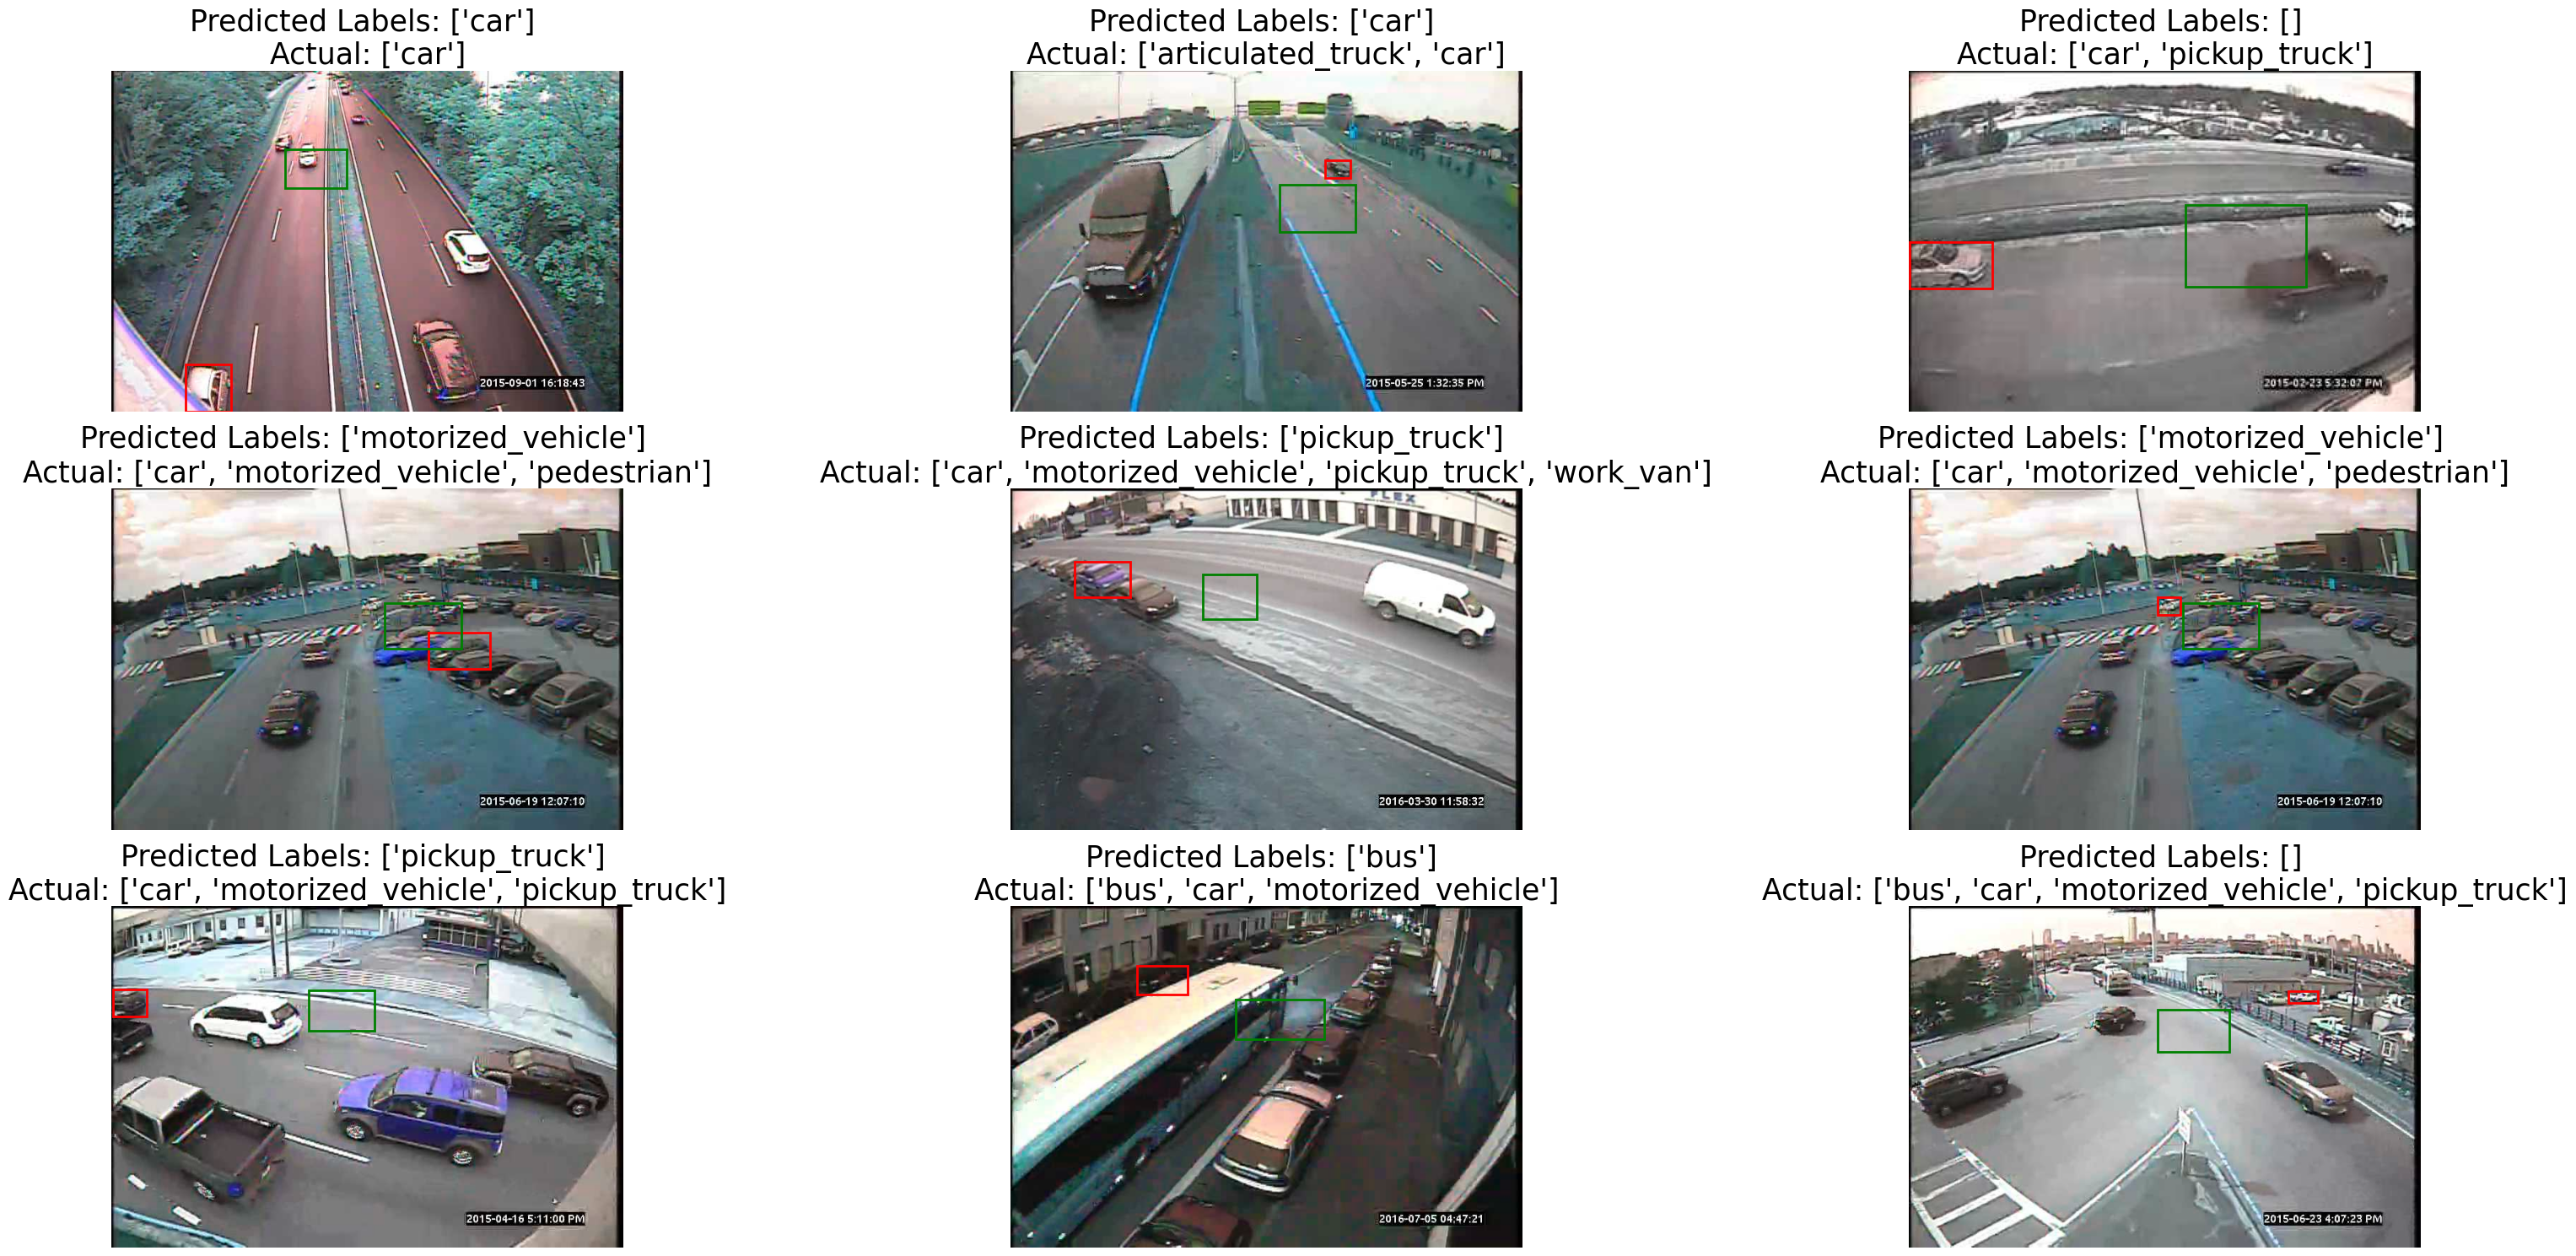

In [156]:
print('Green Boxes: Predicted Box')
print('Red Boxes: Actual Box')
plot_bounding_boxes_with_predictions(X_test_original, y_test, bbox_test, class_names, bbox_preds_test)

# 💯 | **Training a YOLOv8 Nano Model on this Dataset**

## 📄 | Step 1: Preprocess the Data to convert to YOLO's expected formatting

### Create mapping to label values (rather than one hot encode)

In [3]:
# Map object class names to integer IDs (modify this mapping based on your classes)
class_map = {
    'articulated_truck': 0,
    'bicycle': 1,
    'bus': 2,
    'car':3,
    'motorcycle': 4,
    'motorized_vehicle': 5,
    'non-motorized_vehicle': 6,
    'pedestrian': 7,
    'pickup_truck': 8,
    'single_unit_truck': 9,
    'work_van': 10
}

labels_df['class_id'] = labels_df['class'].map(class_map)

### Create an annotation file for the .txt files that we will pass to our YOLO model

#### Defining a function to convert our data to Yolo format

In [4]:
# Function to convert DataFrame rows to YOLO format
def convert_to_yolo(row):
    image_id = row.image_id
    class_id = row.class_id
    x_min = row.x_min
    y_min = row.y_min
    x_max = row.x_max
    y_max = row.y_max
    
    # Load the image to get its dimensions
    img_path = os.path.join(images_dir, f"{image_id}.jpg")
    img = cv2.imread(img_path)
    if img is None:
        return None
    
    img_height, img_width, _ = img.shape  # Get image dimensions
    
    # Calculate normalized bounding box coordinates
    x_center = (x_min + x_max) / (2 * img_width)
    y_center = (y_min + y_max) / (2 * img_height)
    bbox_width = (x_max - x_min) / img_width
    bbox_height = (y_max - y_min) / img_height
    
    # Format the annotation in YOLO format
    yolo_annotation = f"{class_id} {x_center} {y_center} {bbox_width} {bbox_height}"
    
    return yolo_annotation, image_id

#### Create an actual text file for each photos annotations (with class_id and all bounding box values in YOLO format)

In [5]:
# Group annotations by image ID and collect them in a dictionary
annotations_by_image = {}
for row in labels_df.itertuples(index=False):
    yolo_annotation, image_id = convert_to_yolo(row)
    if yolo_annotation is not None:
        if image_id not in annotations_by_image:
            annotations_by_image[image_id] = []
        annotations_by_image[image_id].append(yolo_annotation)

# Save YOLO-formatted annotations to separate text files for each image
output_dir = 'yolo_annotations'
os.makedirs(output_dir, exist_ok=True)

for image_id, annotations in annotations_by_image.items():
    txt_filename = os.path.join(output_dir, f'{image_id}.txt')
    with open(txt_filename, 'w') as f:
        for annotation in annotations:
            f.write(annotation + '\n')

print("Annotations converted to YOLO format and saved successfully.")

Annotations converted to YOLO format and saved successfully.


#### Create Train and Test data folders with an images folder and labels folder in the format YOLO prefers

In [6]:
# Define paths
annotations_dir = 'yolo_annotations/'
images_dir = 'Images/'
output_dir_train = 'train_data'
output_images_dir = os.path.join(output_dir_train, 'images')
output_labels_dir = os.path.join(output_dir_train, 'labels')
output_dir_test = 'test_data' 
test_images_dir = os.path.join(output_dir_test, 'images') 
test_labels_dir = os.path.join(output_dir_test, 'labels')  

# List all image IDs based on YOLO annotation files
image_ids = [filename.split('.')[0] for filename in os.listdir(annotations_dir) if filename.endswith('.txt')]

# Ensure the number of test images does not exceed the total number of images
num_test_images = 62 #20% of the 307 images

# Randomly select a subset of image IDs for testing
test_image_ids = random.sample(image_ids, num_test_images)

# Create output directories for training and test sets
os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_labels_dir, exist_ok=True)
os.makedirs(test_images_dir, exist_ok=True)
os.makedirs(test_labels_dir, exist_ok=True)

# Move files to training and testing directories
for image_id in image_ids:
    annotation_file = os.path.join(annotations_dir, f'{image_id}.txt')
    image_file = os.path.join(images_dir, f'{image_id}.jpg')
    
    if image_id in test_image_ids:
        # Move to test image directory
        shutil.move(image_file, os.path.join(test_images_dir, f'{image_id}.jpg'))
        
        # Move to test label directory
        shutil.move(annotation_file, os.path.join(test_labels_dir, f'{image_id}.txt'))
    else:
        # Move to training image directory
        shutil.move(image_file, os.path.join(output_images_dir, f'{image_id}.jpg'))
        
        # Move to training label directory
        shutil.move(annotation_file, os.path.join(output_labels_dir, f'{image_id}.txt'))

print(f"Split {len(image_ids) - num_test_images} images into training set and {num_test_images} images into testing set.")

Split 246 images into training set and 62 images into testing set.


## 👷‍♂️ | Step 2: Build and Train the YOLOv8 Nano model

In [8]:
from ultralytics import YOLO

In [ ]:
# yolo_model = YOLO('yolov8n.yaml')

# results = yolo_model.train(data='config.yaml', epochs=20)

#### **The above code kept crashing my Kernel so I initiated a seperate virtual environment in which my YOLOv8 Nano model was trained and tested**

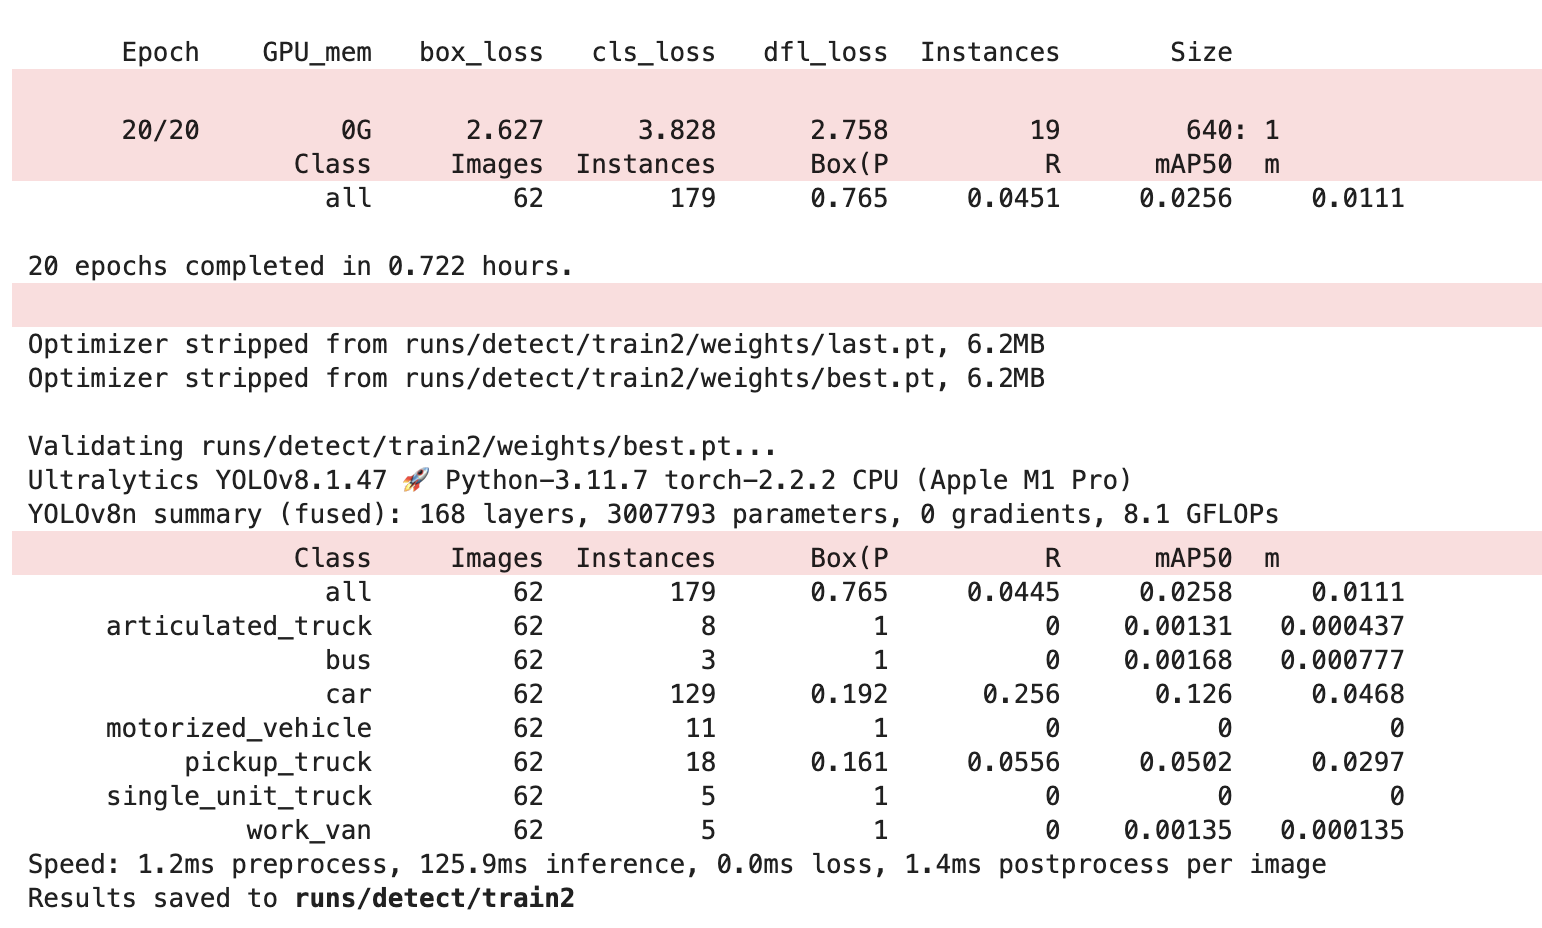

## 📈 | Step 3: Evaluate the YOLOv8 Model
* Note: After running the YOLO model in my virtual environment, I copied over the 'runs' folder the results went into to this notebook

### Display Trainig Results

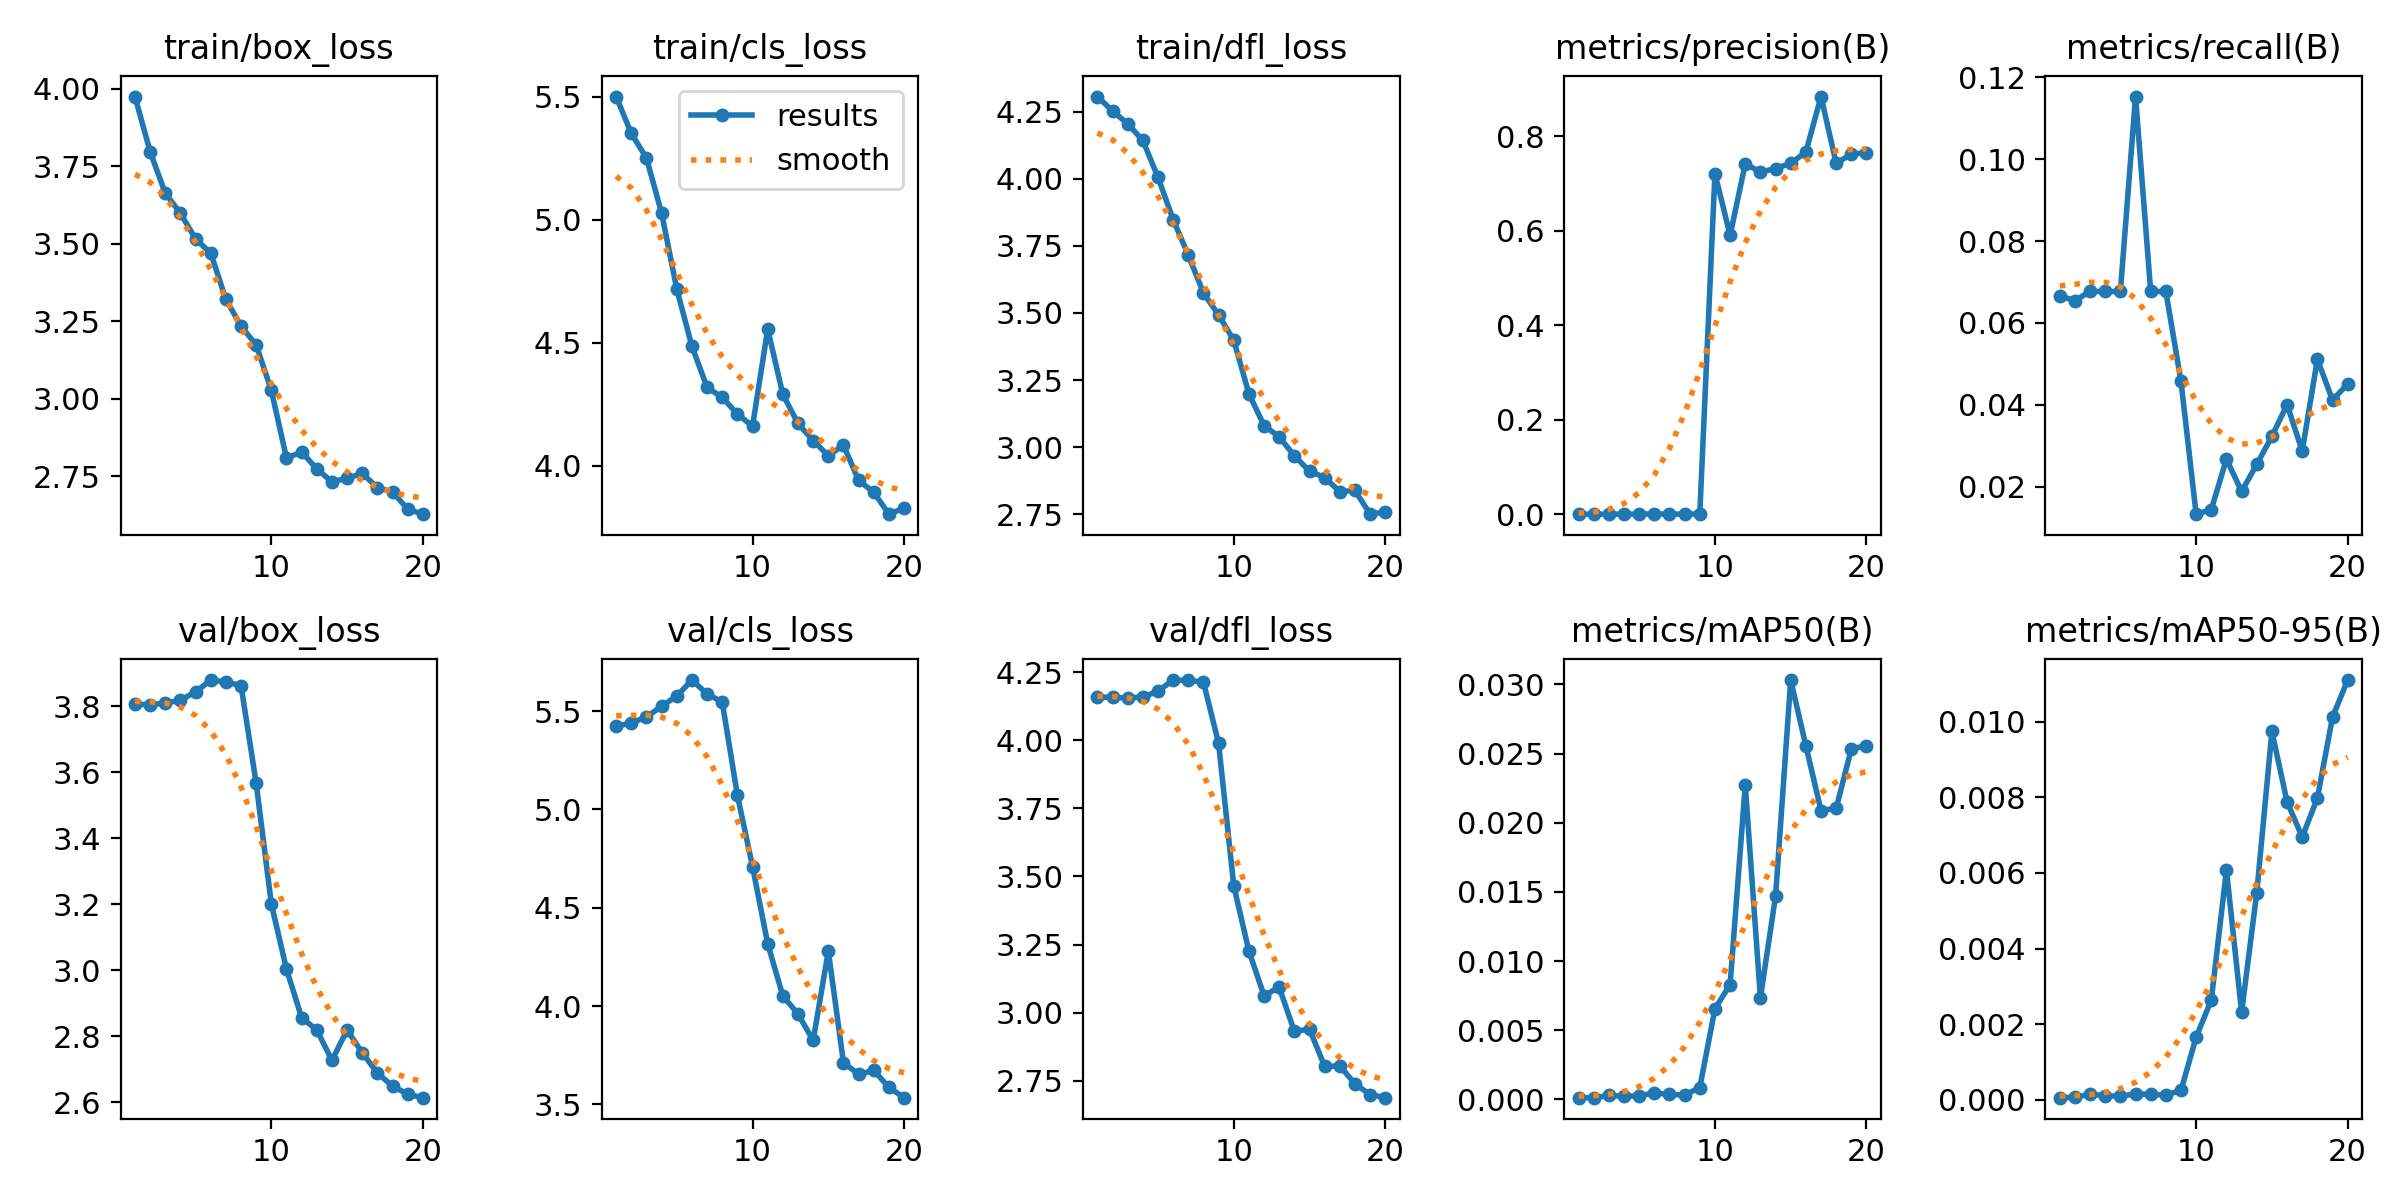

In [158]:
from IPython.display import Image, display
from PIL import Image as PILImage

yolo_dir = 'runs/detect/train2/'
evaluation_imgs = ['results.png', 'R_curve.png', 'P_curve.png', 'F1_curve.png']

results_path = os.path.join(yolo_dir, evaluation_imgs[0])
display(Image(filename=results_path))

### Display various validation metrics

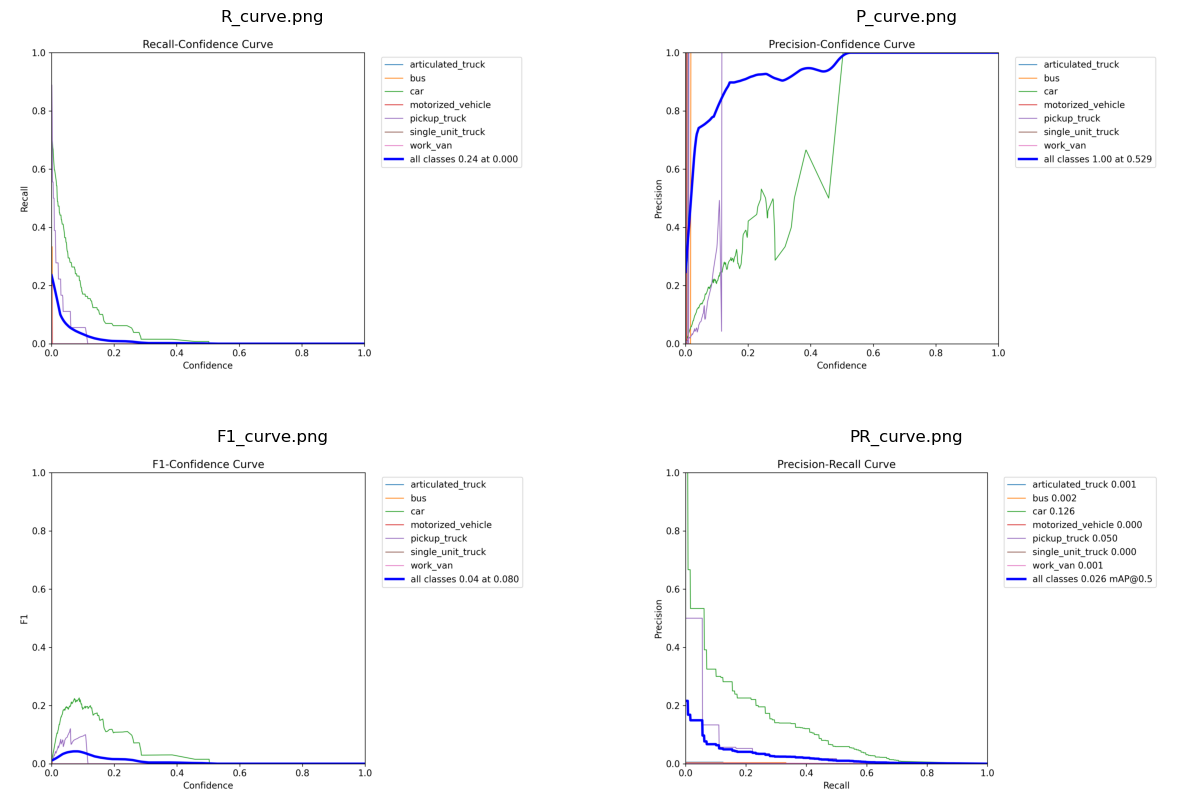

In [160]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Flatten the axes array to easily iterate over them
axes = axes.flatten()

# Iterate over each image filename and corresponding axis
for i, img_filename in enumerate(evaluation_imgs[1:]):
    # Construct the full path to the image
    img_path = os.path.join(yolo_dir, img_filename)

    img = PILImage.open(img_path)
        
    # Display the image on the corresponding subplot
    axes[i].imshow(img)
    axes[i].set_title(img_filename)  # Set subplot title as image filename
    axes[i].axis('off')

## 🚐 | Step 4: Visualize Validation Results

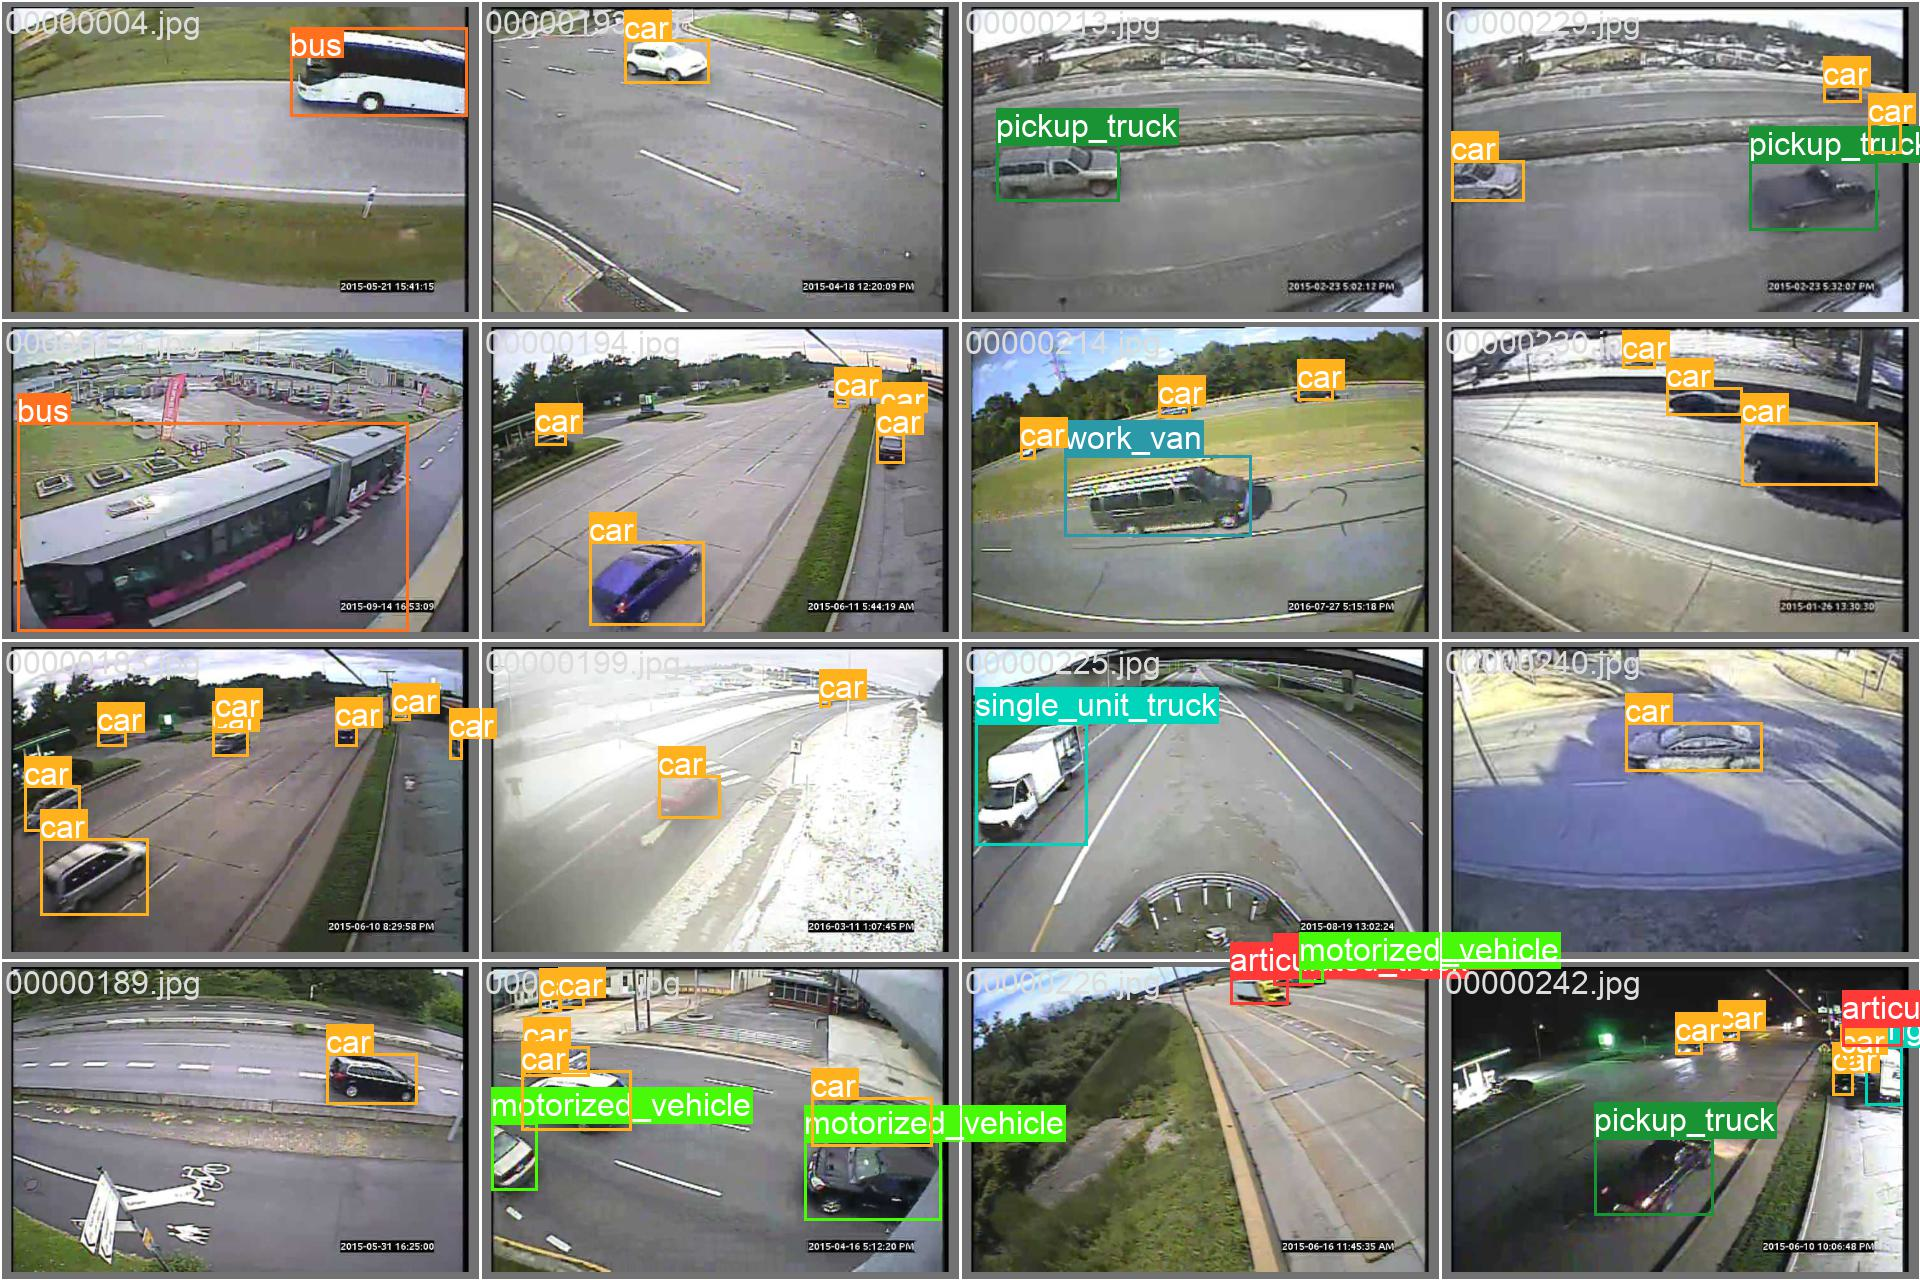

In [161]:
val_batch0_path = os.path.join(yolo_dir, 'val_batch0_labels.jpg')
display(Image(filename=val_batch0_path))

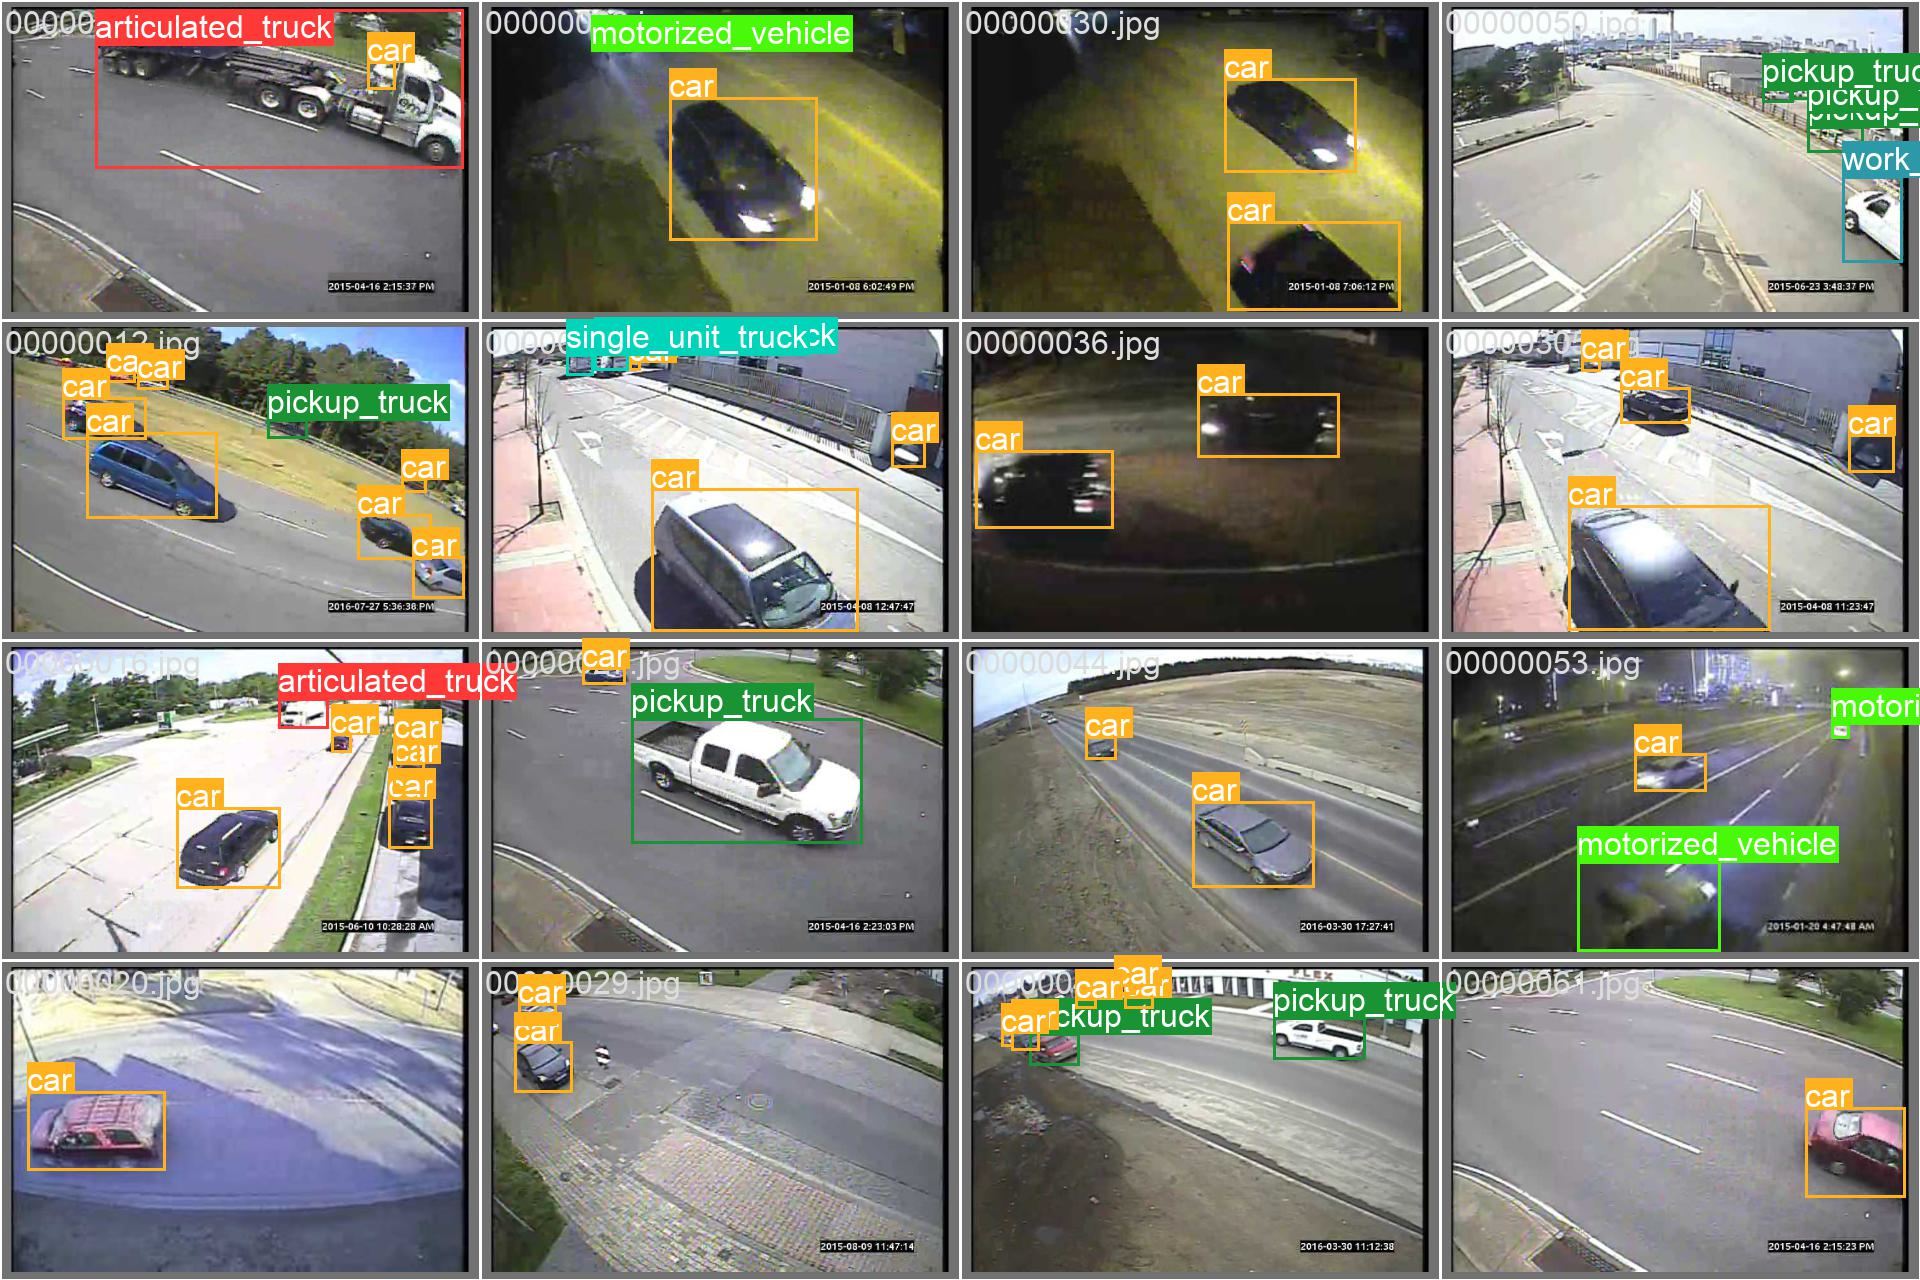

In [162]:
val_batch1_path = os.path.join(yolo_dir, 'val_batch1_labels.jpg')
display(Image(filename=val_batch1_path))